In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit import BasicAer

In [2]:
# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

/tmp/ipykernel_787/3447482214.py:2: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import GroundStateEigensolver
/tmp/ipykernel_787/3447482214.py:2: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import GroundStateEigensolver


In [104]:
def execute_circuit(circuit, backend=Aer.get_backend('qasm_simulator'), shots=1024):
    job = execute(circuit, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def count_to_prob(counts):
    shots = sum(counts.values())
    n_qubits = len(list(counts.keys())[0])
    probs = np.zeros(2**n_qubits)
    for key, value in counts.items():
        probs[int(key, 2)] = value/shots
    return probs

def get_statevector(circuit, backend=Aer.get_backend('statevector_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    statevector = result.get_statevector(circuit)
    return statevector

def get_unitary(circuit, backend=Aer.get_backend('unitary_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    unitary = result.get_unitary(circuit)
    return unitary

# Variational Quantum Eigensolver (VQE)

The VQE algorithm is a hybrid quantum-classical algorithm that uses a variational technique to find the minimum eigenvalue of the Hamiltonian of a given system. The algorithm is based on the variational principle, which states that for any state $|\psi\rangle$ and Hamiltonian $H$, the expectation value $\langle\psi|H|\psi\rangle$ is greater than or equal to the ground state energy of $H$. The algorithm uses a parameterized quantum circuit to prepare a trial state $|\psi(\theta)\rangle$ and a classical optimizer to find the parameters $\theta$ that minimize the expectation value $\langle\psi(\theta)|H|\psi(\theta)\rangle$. The expectation value is evaluated by sampling from the trial state prepared by the quantum circuit. The process is repeated until the parameters converge to the optimal value.


## Hidrogen Molecular Ground State

In this notebook we will use the VQE algorithm to find the ground state energy of the hidrogen molecule. The Hamiltonian of the hidrogen molecule is given by

$$H_{\text{molec}} = -\sum_i \frac{\nabla R_i^2}{2M_i} - \sum_i \frac{\nabla r_i^2}{2} - \sum_{i,j>i} \frac{Z_i}{\left|R_i - r_j\right|}
        \quad + \sum_{i,j>i} \frac{Z_i Z_j}{\left|R_i - R_j\right|} + \sum_{i,j>i} \frac{1}{\left|r_i - r_j\right|},
 $$

In the second quantization formalism, the Hamiltonian can be written as

$$H_{\text{elec}} = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s,$$

where $h_{pq}$ and $h_{pqrs}$ are the one- and two-electron integrals, respectively.

To find the ground state energy of the hidrogen molecule, we will use the VQE algorithm for that we need to express the Hamiltonian in terms of Pauli matrices. The transformation of creation and annihilation operators to Pauli matrices can be done using a Parity mapper transformation. Any fermionic operator $a_p^\dagger a_q$ can be transformed into a tensor product of Pauli matrices and Qiskit provides a function to do this transformation.



Ref: https://www.degruyter.com/document/doi/10.1515/phys-2021-0071/html

## 1. Define the Molecule Geometry

The Hidrogen molecule is composed by two hidrogen atoms. The distance between the atoms is called bond length and is denoted by $d$. The bond length is a parameter of the hidrogen molecule and can be changed to study the molecule properties. In this notebook we will use the bond length $d=0.735$ Angstroms.

**Charge:** The hidrogen molecule is neutral, so the charge of the molecule is zero.

**Multiplicity:** The hidrogen molecule is composed by two electrons. The multiplicity is defined as $2S+1$, where $S$ is the total spin of the molecule. The hidrogen molecule has $S=0$, so the multiplicity is $1$.

In [7]:
d = 0.735

hydrogen_molecule = [
    ['H', [0.0, 0.0, 0.0]],
    ['H', [0.0, 0.0, d]]
]

H2 = Molecule(geometry=hydrogen_molecule, charge=0, multiplicity=1)

driver = ElectronicStructureMoleculeDriver(H2, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)
properties = driver.run()

/home/leander/miniconda3/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [8]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

number of alpha electrons:  1
number of beta electrons:  1
number of spin orbitals:  4
nuclear repulsion energy:  0.7199689944489797


## 2. Define the Hamiltonian

Here we will define the Hamiltonian of the hidrogen molecule. The Hamiltonian is defined in the second quantization formalism. The Hamiltonian is composed by two terms: the electronic Hamiltonian and the nuclear repulsion energy.

In [10]:
problem = ElectronicStructureProblem(driver)

# generate the second-quantized operators
problem_ops = problem.second_q_ops()
problem_ops

{'ParticleNumber': FermionicOp([('+_0 -_0', (1+0j)), ('+_1 -_1', (1+0j)), ('+_2 -_2', (1+0j)), ('+_3 -_3', (1+0j))], register_length=4, display_format='sparse'),
 'ElectronicEnergy': FermionicOp([('+_0 -_0', -1.25633907300325), ('+_1 -_1', -0.47189600728114184), ('+_2 -_2', -1.25633907300325), ('+_3 -_3', -0.47189600728114184), ('+_0 +_0 -_0 -_0', -0.33785507740175813), ('+_0 +_1 -_1 -_0...)], register_length=4, display_format='sparse'),
 'DipoleMomentX': FermionicOp([('', 0j)], register_length=4, display_format='sparse'),
 'DipoleMomentY': FermionicOp([('', 0j)], register_length=4, display_format='sparse'),
 'DipoleMomentZ': FermionicOp([('+_0 -_0', 0.6944743507776598), ('+_0 -_1', -0.927833470459232), ('+_1 -_0', -0.9278334704592321), ('+_1 -_1', 0.6944743507776604), ('+_2 -_2', 0.6944743507776598), ('+_2 -_3', -0.9278334704592...)], register_length=4, display_format='sparse'),
 'AngularMomentum': FermionicOp([('+_0 -_0', (0.75+0j)), ('+_1 -_1', (0.75+0j)), ('+_2 -_2', (0.75+0j)), ('

## 3. Mapping the Hamiltonian to Qubit Operators

As mentioned before, the Hamiltonian is mapped to qubit operators using a parity transformation. But, there are other transformations that can be used to map the Hamiltonian to qubit operators such as:
- Bravyi-Kitaev transformation
- Jordan-Wigner transformation

In [33]:
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper, two_qubit_reduction=True)

qubit_op = converter.convert(problem_ops["ElectronicEnergy"], num_particles=problem.num_particles)
print(qubit_op)

-1.0523732457728596 * II
+ 0.39793742484317934 * IZ
- 0.3979374248431794 * ZI
- 0.01128010425623524 * ZZ
+ 0.18093119978423128 * XX


## 4. Classical Solution

In [34]:
from qiskit.algorithms import NumPyMinimumEigensolver

solver = GroundStateEigensolver(converter, NumPyMinimumEigensolver()) 
Exact_solution = solver.solve(problem).total_energies[0]
print('Exact Solution : ', Exact_solution)

Exact Solution :  -1.137306035753396


/tmp/ipykernel_787/178153325.py:3: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  solver = GroundStateEigensolver(converter, NumPyMinimumEigensolver())


## 5. Define the Ansatz

In [35]:
ansatz = UCCSD(
    qubit_converter=converter,
    num_particles=problem.num_particles, 
    num_spin_orbitals=problem.num_spin_orbitals,
)

## 6. Optimization

In [36]:
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.primitives import Estimator, BackendEstimator

In [37]:
convergence = []
job_list = []

estimator = Estimator()

def evaluate_expectation(x):
    x = list(x)
    
    estimator_result = estimator.run([ansatz], [qubit_op], parameter_values=[x])
    job = estimator_result.result()
    results = job.values[0]
    job_list.append(job)
    
    return np.real(results)

def callback(x,fx,ax,tx,nx):
    convergence.append(evaluate_expectation(fx))

initial_point = np.random.random(ansatz.num_parameters)
optimizer = SPSA(maxiter=50, callback=callback)


result =  optimizer.minimize(evaluate_expectation, initial_point)

In [38]:
from qiskit.algorithms import MinimumEigensolverResult

In [39]:
Energy_H2_t = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol_aux = problem.interpret(sol)
    sol = sol_aux.total_energies[0]
    Energy_H2_t.append(sol)
print("Computed Energy:", Energy_H2_t[-1])

Computed Energy: -1.1369050892307624


/tmp/ipykernel_787/927704890.py:3: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.minimum_eigen_solver.MinimumEigensolverResult`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.MinimumEigensolverResult``. See https://qisk.it/algo_migration for a migration guide.
  sol = MinimumEigensolverResult()


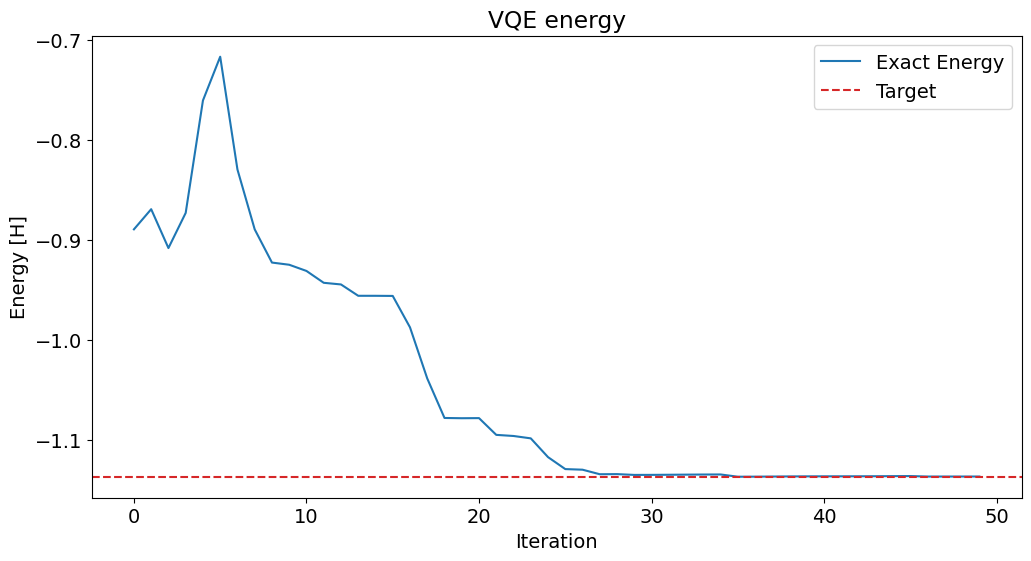

In [41]:

plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H2_t, label="Exact Energy")
plt.axhline(y=Exact_solution.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

# Variational Quantum Eigensolver (VQE) (Handmade)

In [170]:
import re

def get_paulis(qubit_op):
    str_qubit_op = qubit_op.__str__()
    str_qubit_op = str_qubit_op.split('\n')
    paulis = []
    coeffs = []


    for i in range(len(str_qubit_op)):
        coeffs.append(qubit_op.to_pauli_op()[i].coeff)
        paulis.append(re.findall(r"[A-Z][a-z]*", str_qubit_op[i]))

    return paulis, coeffs

def measure_hamiltonian(anzatz, params, qubit_op):
    paulis, coeffs = get_paulis(qubit_op)

    expt_val = 0
    for i in range(len(paulis)):
        p_op = paulis[i]
        coeff = coeffs[i]

        qc = anzatz(params)

        for nq, p in enumerate(p_op):
            if p == 'X':
                qc.h(nq)
            elif p == 'Y':
                qc.sdg(nq)
                qc.h(nq)
        
        [ qc.measure(nq, nq) for nq, p in enumerate(p_op)]

        counts = execute_circuit(qc)
        probs = count_to_prob(counts)

        eigen_vals = []
        for p in p_op:
            if p == 'I':
                eigen_vals.append([1, 1])
            else:
                eigen_vals.append([1, -1])

        eig_vals = eigen_vals[0]
        for k in range(1, len(eigen_vals)):
            eig_vals = np.kron(eig_vals, eigen_vals[k])

        expt_val += coeff * np.dot(eig_vals, probs)

    return expt_val


## 1. Define the Anzatz

In [169]:
def ansatz_circuit(params):
    
    #### COMPLETE THE CODE BELOW ####


    # Return the quantum circuit with the ansatz
    pass

## 2. Optimization

In [156]:
results = []

estimate_expt_val = lambda params: measure_hamiltonian(ansatz_circuit, params, qubit_op)

def callback(x,fx,ax,tx,nx):
    results.append(measure_hamiltonian(ansatz_circuit, fx, qubit_op))


initial_point = np.random.random(4)
optimizer = SPSA(maxiter=50, callback=callback)


result =  optimizer.minimize(estimate_expt_val, initial_point)

In [157]:
Energy_H2_t = []
for i in range(len(results)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = results[i]
    sol_aux = problem.interpret(sol)
    sol = sol_aux.total_energies[0]
    Energy_H2_t.append(sol)
print("Computed Energy:", Energy_H2_t[-1])

Computed Energy: -1.1360859285547673


/tmp/ipykernel_787/1574098258.py:3: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.minimum_eigen_solver.MinimumEigensolverResult`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.MinimumEigensolverResult``. See https://qisk.it/algo_migration for a migration guide.
  sol = MinimumEigensolverResult()


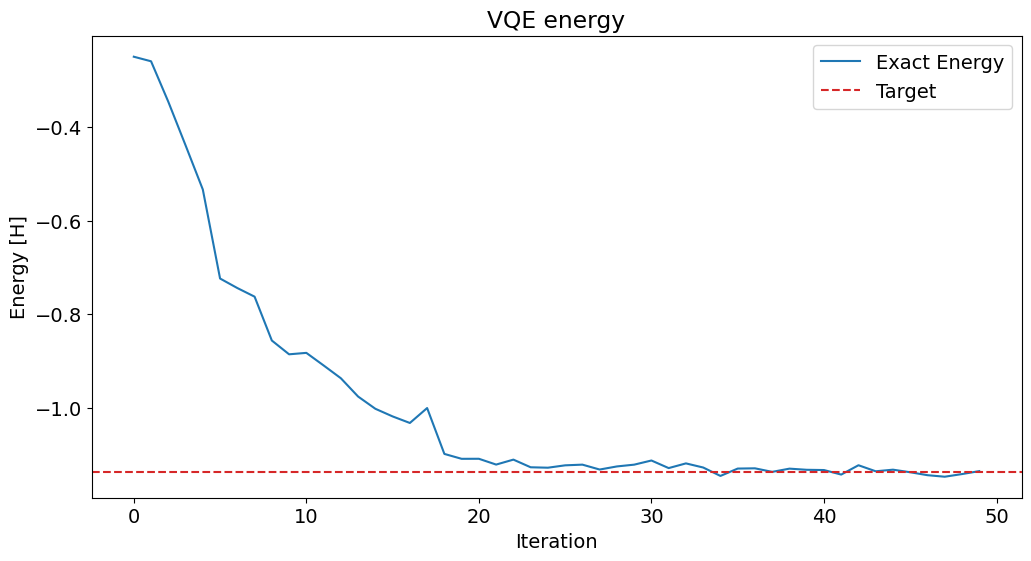

In [158]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H2_t, label="Exact Energy")
plt.axhline(y=Exact_solution.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

# H2 Energy vs Bond Length

In [167]:
bond_length = np.linspace(0.2, 3.0, 20)
exact_energy = []
vqe_energy = []

##### COMPLETE THE CODE BELOW #####
    
    

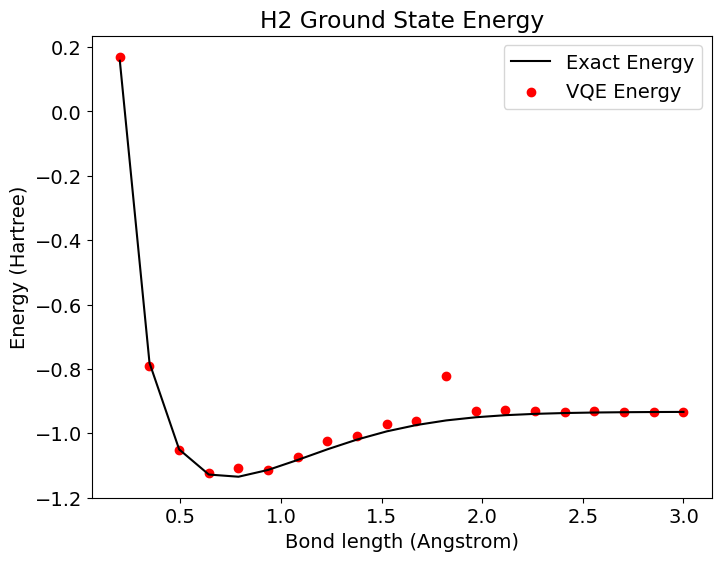

In [166]:
# Make the plot Energy vs. bond length

fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')

ax.plot(bond_length, exact_energy, label="Exact Energy", color="black")
ax.scatter(bond_length, vqe_energy, label="VQE Energy", marker='o', color='red')

ax.set_xlabel("Bond length (Angstrom)")
ax.set_ylabel("Energy (Hartree)")
ax.set_title("H2 Ground State Energy")

ax.legend(loc="best")